# LOESS Trend Analysis

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess

from common import RFOOTER
LFOOTER = "Australia. Polling data sourced from Wikipedia. "
SHOW_PLOT = True

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/LOESS-trend/")
mg.clear_chart_dir()

## Upload the data

In [3]:
def load_polling_data() -> pd.DataFrame:
    """Load the most recent polling data with data freshness validation."""
    today = pd.Timestamp.now().strftime('%Y-%m-%d')
    data_dir = Path("../poll-data")

    # Look for today's file first
    today_file = data_dir / f"voting_intention_next_{today}.csv"
    fallback_file = data_dir / "voting_intention_next.csv"

    if today_file.exists():
        data_path = today_file
        print(f"Using today's data file: {data_path}")
    else:
        # Look for any recent file with date suffix
        pattern = "voting_intention_next_*.csv"
        recent_files = list(data_dir.glob(pattern))
        
        if recent_files:
            # Sort by filename (date suffix) and take most recent
            most_recent = sorted(recent_files)[-1]
            file_date = most_recent.stem.split('_')[-1]  # Extract date from filename
            
            print(f"⚠️  WARNING: No data file found for today ({today})")
            print(f"Using most recent file: {most_recent} (from {file_date})")
            print(f"Consider running the scraper first: python scrape_wikipedia_polls.py")
            data_path = most_recent
        elif fallback_file.exists():
            print(f"⚠️  WARNING: No dated data files found")
            print(f"Using fallback file: {fallback_file}")
            print(f"Consider running the scraper first: python scrape_wikipedia_polls.py")
            data_path = fallback_file
        else:
            raise FileNotFoundError(f"No polling data files found. Please run the scraper first: python scrape_wikipedia_polls.py")

    # Load the data
    df = pd.read_csv(data_path)
    df.index = pd.PeriodIndex(df['parsed_date'], freq='D')

    df = df.dropna(axis=1, how='all')  # drop all NAN columns

    return df


data = load_polling_data()

⚠️  WARNING: No data file found for today (2025-07-24)
Using most recent file: ../poll-data/voting_intention_next_2025-07-23.csv (from 2025-07-23)
Consider running the scraper first: python scrape_wikipedia_polls.py


## Data Preview

In [4]:
def preview_polling_data(data: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(data.head(10))

# Show the data preview
preview_polling_data(data)

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date
parsed_date,,,,,,,,,,,,,
2025-07-15,13 – 18 Jul 2025,Resolve,Telephone/Online,2311,35.0,29.0,12.0,8.0,8.0,8.0,56.0,44.0,2025-07-15
2025-07-15,14 – 17 Jul 2025,Newspoll,Online,1264,36.0,29.0,12.0,8.0,NaN,15.0,57.0,43.0,2025-07-15
2025-07-05,5 – 6 Jul 2025,DemosAU,Online,1199,36.0,26.0,14.0,9.0,NaN,15.0,59.0,41.0,2025-07-05
2025-06-29,27 Jun – 1 Jul 2025,Spectre Strategy,Online,1001,35.9,31.0,12.8,7.9,NaN,12.3,56.5,43.5,2025-06-29
2025-06-25,Late June 2025,Redbridge,Online,4036,NaN,NaN,NaN,NaN,NaN,NaN,55.5,44.5,2025-06-25
2025-06-26,23 – 29 Jun 2025,Roy Morgan,Online,1522,36.5,30.5,12.0,8.5,NaN,12.5,57.5,42.5,2025-06-26
2025-06-12,2 – 22 Jun 2025,Roy Morgan,Online,3957,37.5,31.0,12.0,6.0,NaN,13.5,58.0,42.0,2025-06-12
2025-05-18,5 May – 1 Jun 2025,Roy Morgan,Online,5128,37.0,31.0,11.5,6.0,NaN,14.5,58.5,41.5,2025-05-18


## LOESS Smoothing

In [5]:
def create_loess_smoothing(data: pd.DataFrame, column: str, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_2pp_sorted = data.sort_index().copy()
    
    # Apply LOESS smoothing
    series = df_2pp_sorted[column].dropna()
    dates_as_ordinals = [p.ordinal for p in series.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1
    smoothed = lowess(
        df_2pp_sorted[column].dropna(), 
        dates_as_ordinals,
        frac=fraction  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=series.index)
    smoothed_series.name = f'LOESS {day_span}-day smoothing'
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep='first')]
    print(f"LOESS smoothing created for {column} with day span {day_span} and length {len(smoothed_series)}.")
    return smoothed_series

In [6]:
def create_chart_with_loess(df_2pp: pd.DataFrame, smoothed: pd.Series, color: str, name: str, col: str, f:str="") -> None:
    """Create and display the LOESS chart with polling data."""

    fig, ax = plt.subplots()
    symbols = ['o', 's', '^', 'v', '<', '>', 'D', 'x', 'v']
    for i, label in enumerate(sorted(df_2pp['Brand'].unique())):
        selection = df_2pp[df_2pp['Brand'] == label][col]
        if selection.empty or selection.isna().all():
            continue
        x = [p.ordinal  for p in selection.index]
        y = selection.to_numpy()
        ax.scatter(x, y, label=label, color=color, s=20, marker=symbols[i % len(symbols)])

    mg.line_plot_finalise(
        smoothed,
        ax=ax,
        title=f"{name} - {col} - Trend",
        xlabel=None,
        ylabel=f"{col} (%)",
        legend=True,
        width=2.5,
        color=color,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} {f}",
        show=SHOW_PLOT,
    )

LOESS smoothing created for Primary vote ALP with day span 90 and length 6.


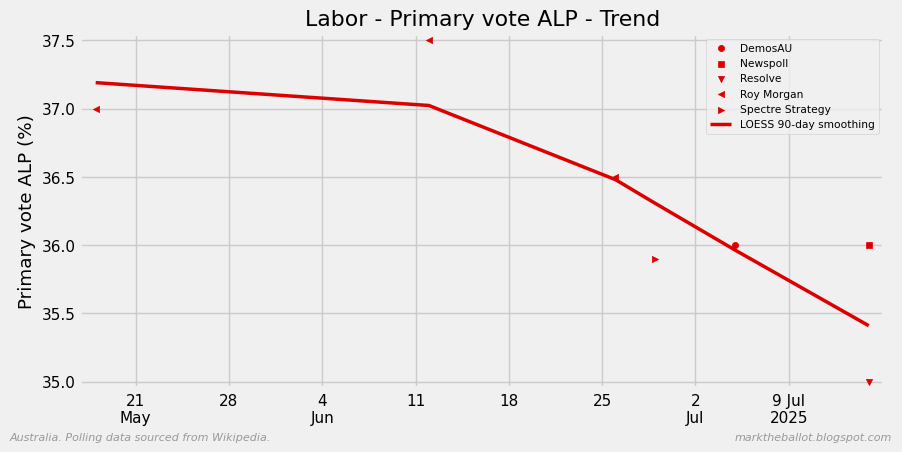

LOESS smoothing created for Primary vote L/NP with day span 90 and length 6.


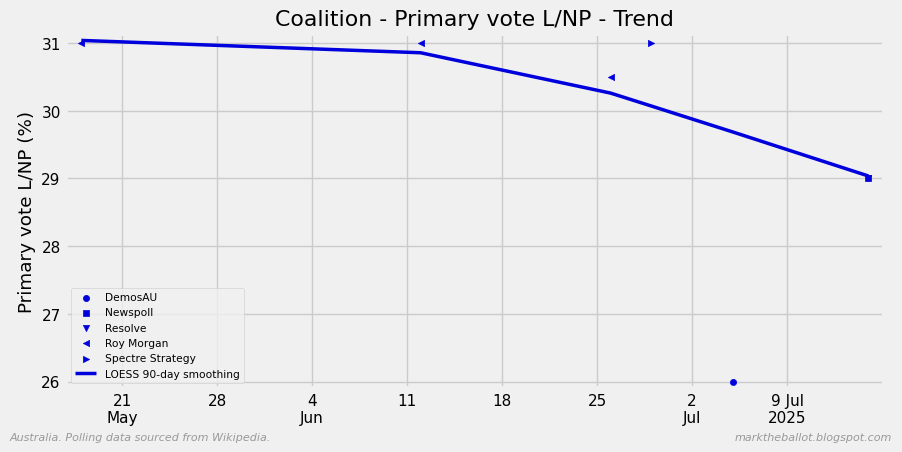

LOESS smoothing created for Primary vote GRN with day span 90 and length 6.


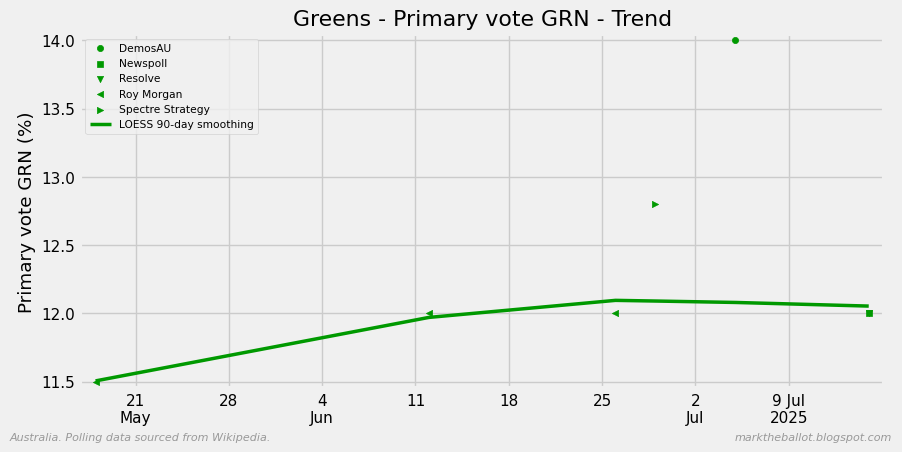

LOESS smoothing created for Primary vote ONP with day span 90 and length 6.


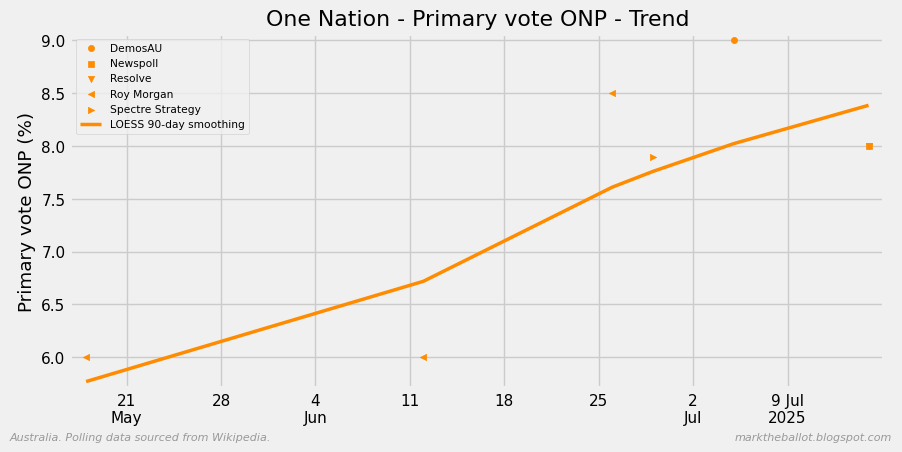

LOESS smoothing created for 2PP vote ALP with day span 90 and length 7.


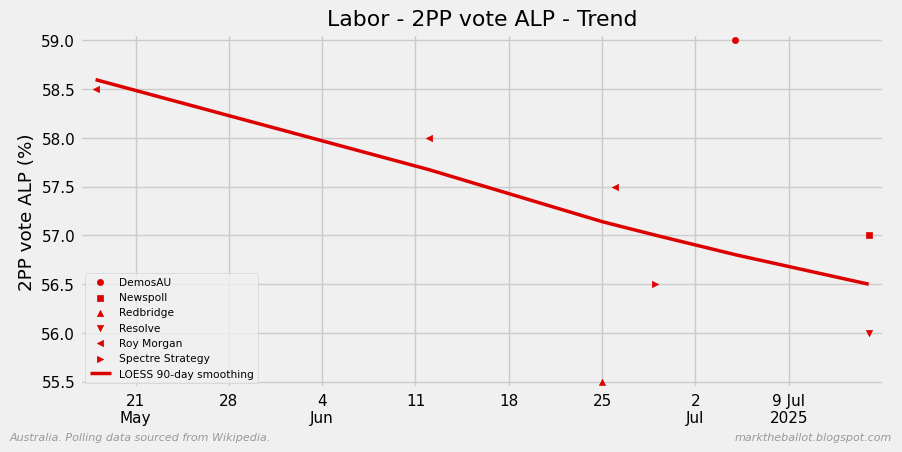

LOESS smoothing created for 2PP vote L/NP with day span 90 and length 7.


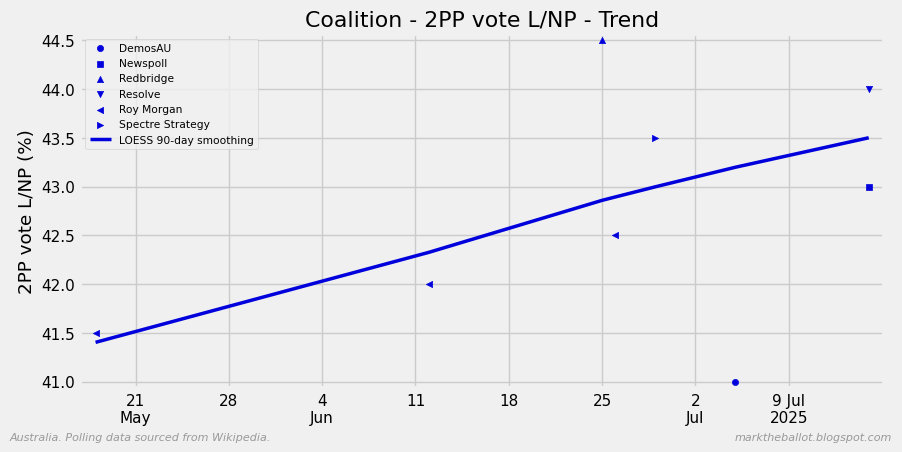

LOESS smoothing created for Others Primary Vote with day span 90 and length 6.


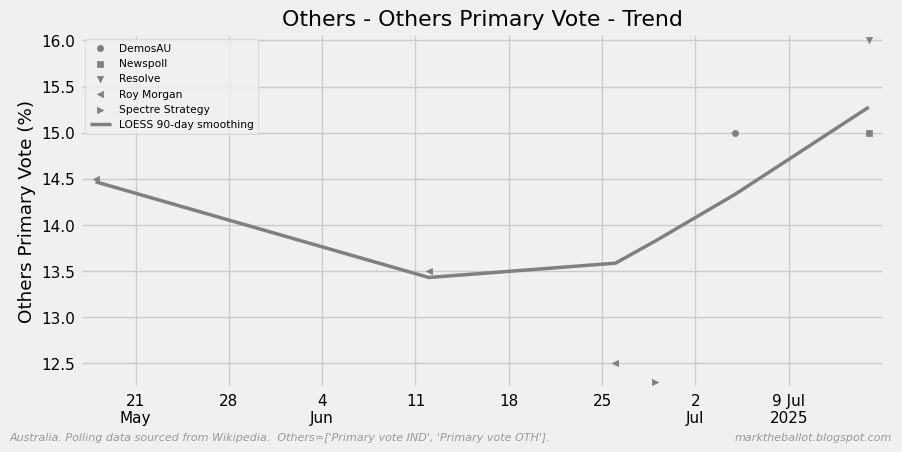

In [7]:
wanted = {
    # party: [name, color]
    "ALP": ['Labor', "#dd0000"],
    "L/NP": ['Coalition', "#0000dd"],
    "GRN": ['Greens', "#009900"],
    "ONP": ['One Nation', "darkorange"],
}
used = []
for col in data.columns:
    if "vote" not in col:
        continue
    for w in wanted:
        if w in col:
            used.append(col)
            name, color = wanted[w]
            smoothed = create_loess_smoothing(data, col)
            create_chart_with_loess(data, smoothed, color, name, col,)

# Create chart for "Others Primary Vote"
remaining = [w for w in data.columns if w not in used and "vote" in w]
col = 'Others Primary Vote'
data[col] = data[remaining].sum(axis=1, skipna=True)
problematic = data[remaining].isna().all(axis=1)
data.loc[problematic, col] = np.nan  # Ensure problematic rows are NaN
smoothed = create_loess_smoothing(data, col)
create_chart_with_loess(data, smoothed, "grey", "Others", col, f=f"Others={remaining}. ")

## Finished

In [8]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-07-24 09:25:39

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

mgplot     : 0.2.11
numpy      : 2.3.1
statsmodels: 0.14.5
matplotlib : 3.10.3
pandas     : 2.3.1
pathlib    : 1.0.1

Watermark: 2.5.0



In [9]:
print("The end.")

The end.
